# To implement a simple version of EM clustering

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### Generating the dataset

In [154]:
m1 = [1, 1]
m2 = [7, 7]
cov1 = [[3, 2], [2, 3]]
cov2 = [[2, -1], [-1, 2]]
x = np.random.multivariate_normal(m1, cov1, size=200)
y = np.random.multivariate_normal(m2, cov2, size=200)
d = np.concatenate((x, y), axis=0)


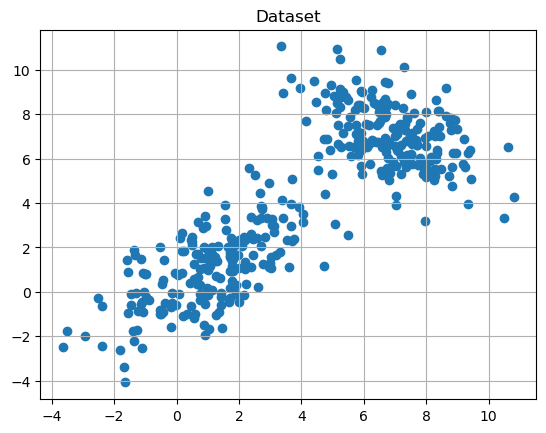

In [155]:
plt.scatter(d[:, 0], d[:, 1],)
plt.title('Dataset')
plt.grid()

### Initializing the mean and covariace of each cluster with random vals

In [156]:
m1 = d[np.random.choice(len(d))]
m2 = d[np.random.choice(len(d))]
cov1 = np.cov(np.transpose(d))
cov2 = np.cov(np.transpose(d))
pi = 0.5

### Plotting the initial state with these values

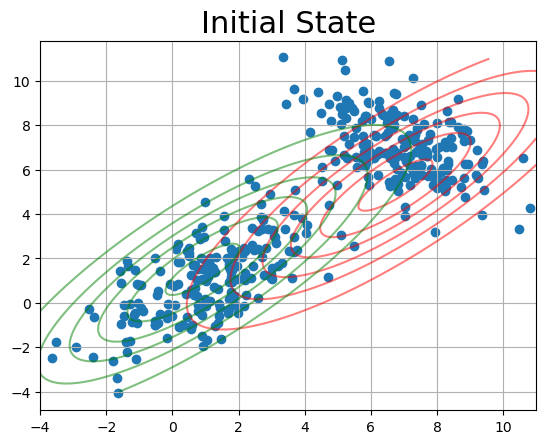

In [157]:
x1 = np.linspace(-4, 11, 200)
x2 = np.linspace(-4, 11, 200)
X, Y = np.meshgrid(x1, x2)
Z1 = multivariate_normal(m1, cov1)
Z2 = multivariate_normal(m2, cov2)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
plt.scatter(d[:, 0], d[:, 1], marker='o')
plt.contour(X, Y, Z1.pdf(pos), colors="r", alpha=0.5)
plt.contour(X, Y, Z2.pdf(pos), colors="g", alpha=0.5)
plt.title('Initial State', fontsize=22)
plt.grid()

### Writing a function for the Expectation step

In [158]:
def Estep(lis1):
    m1 = lis1[0]
    m2 = lis1[1]
    cov1 = lis1[2]
    cov2 = lis1[3]
    pi = lis1[4]
    pt2 = multivariate_normal.pdf(d, mean=m2, cov=cov2)
    pt1 = multivariate_normal.pdf(d, mean=m1, cov=cov1)
    w1 = pi * pt2
    w2 = (1 - pi) * pt1
    eval1 = w1 / (w1 + w2)
    return eval1

### Writing a function for the minimization step

In [159]:
def Mstep(eval1):
    num_mu1,din_mu1,num_mu2,din_mu2=0,0,0,0

    for i in range(0,len(d)):
        num_mu1 += (1-eval1[i]) * d[i]
        din_mu1 += (1-eval1[i])

        num_mu2 += eval1[i] * d[i]
        din_mu2 += eval1[i]

    mu1 = num_mu1/din_mu1
    mu2 = num_mu2/din_mu2

    num_s1,din_s1,num_s2,din_s2=0,0,0,0
    for i in range(0,len(d)):

        q1 = np.matrix(d[i]-mu1)
        num_s1 += (1-eval1[i]) * np.dot(q1.T, q1)
        din_s1 += (1-eval1[i])

        q2 = np.matrix(d[i]-mu2)
        num_s2 += eval1[i] * np.dot(q2.T, q2)
        din_s2 += eval1[i]

    s1 = num_s1/din_s1
    s2 = num_s2/din_s2

    pi = sum(eval1)/len(d)
    
    lis2=[mu1,mu2,s1,s2,pi]
    return(lis2)

### Function to plot the graph at some iterations 

In [160]:
def plot(lis1):
    mu1=lis1[0]
    mu2=lis1[1]
    s1=lis1[2]
    s2=lis1[3]
    Z1 = multivariate_normal(mu1, s1)  
    Z2 = multivariate_normal(mu2, s2)

    pos = np.empty(X.shape + (2,))                # a new array of size 200x200x2
    pos[:, :, 0] = X; pos[:, :, 1] = Y   

    plt.figure(figsize=(5, 5))
    plt.scatter(d[:,0], d[:,1], marker='o')     
    plt.contour(X, Y, Z1.pdf(pos), colors="r" ,alpha = 0.5) 
    plt.contour(X, Y, Z2.pdf(pos), colors="g" ,alpha = 0.5) 
    plt.grid()                                                                         
    plt.show()



### Running the algorithm with some parameters and plotting the results

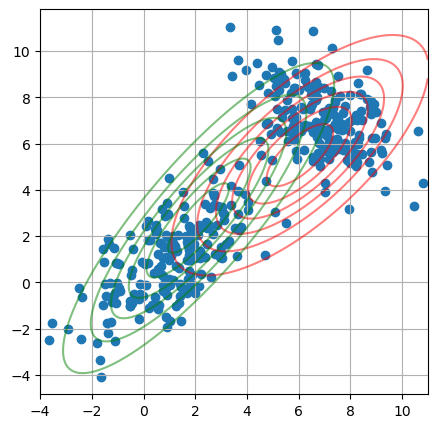

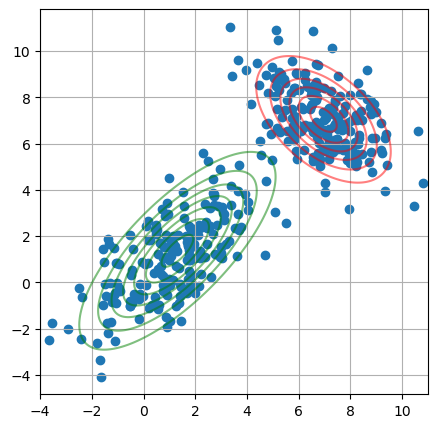

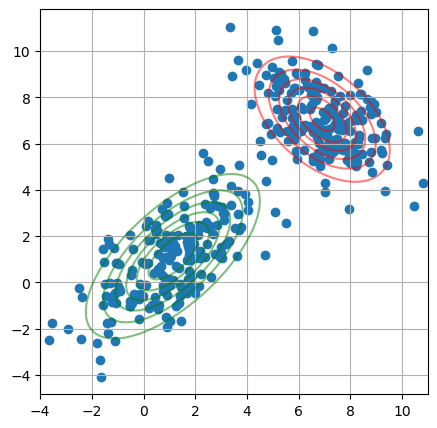

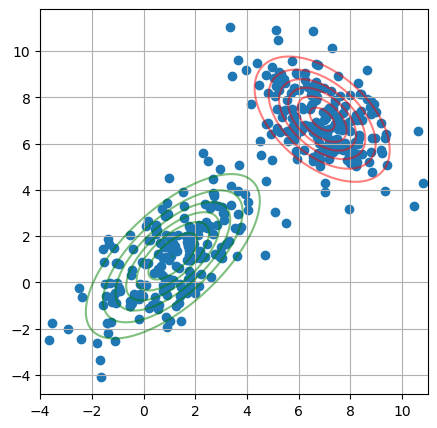

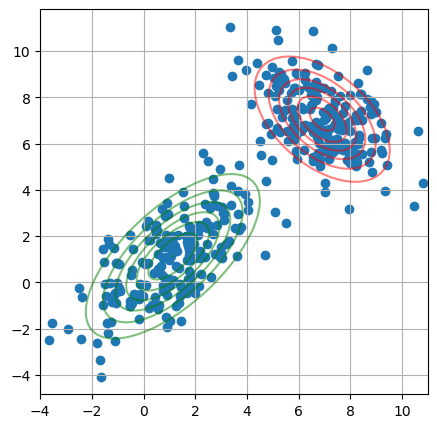

In [161]:
iterations = 20
lis1=[m1,m2,cov1,cov2,pi]
for i in range(0,iterations):
    lis2 = Mstep(Estep(lis1))
    lis1=lis2
    if(i==0 or i==5 or i ==10 or i ==15 or i == 19):
        plot(lis1)